# Eigenfunctions of the Koopman operator

**Adapted from**: Example 2.6 of [MAI20]

[MAI20] Mauroy, Alexandre, Aivar Sootla, and Igor Mezić.
*Koopman framework for global stability analysis.*
The Koopman Operator in Systems and Control: Concepts, Methodologies, and Applications (2020): 35-58.

In [1]:
using DynamicPolynomials
@polyvar x[1:2]

a = 1
I = 0.05
ε = 0.08
γ = 1
F0 = [-x[2] - x[1] * (x[1] - 1) * (x[1] - a) + I, ε * (x[1] - γ * x[2])]

2-element Vector{DynamicPolynomials.Polynomial{true, Float64}}:
 -x₁³ + 2.0x₁² - x₁ - x₂ + 0.05
 0.08x₁ - 0.08x₂

We move equilibrium `(0.0256, 0.0256)` to the origin

In [2]:
x1 = x2 = 0.0256
F = [f(x => [x[1] + x1, x[2] + x2]) for f in F0]

2-element Vector{DynamicPolynomials.Polynomial{true, Float64}}:
 -x₁³ + 1.9232x₁² - 0.89956608x₁ - x₂ + 9.394278400000344e-5
 0.08x₁ - 0.08x₂

We compute the Jacobian at the equilibrium

In [3]:
J = [j(x => zeros(2)) for j in differentiate(F, x)]

2×2 Matrix{Float64}:
 -0.899566  -1.0
  0.08      -0.08

We see that its eigenvalues indeed have negative real part:

In [4]:
using LinearAlgebra
E = eigen(J)

LinearAlgebra.Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
2-element Vector{Float64}:
 -0.7862997172234601
 -0.1932663627765399
vectors:
2×2 Matrix{Float64}:
 -0.993646   0.816807
  0.112547  -0.576911

We set `w` as its dominant eigenvector:

CSDP 6.2.0
Iter:  0 Ap: 0.00e+00 Pobj:  0.0000000e+00 Ad: 0.00e+00 Dobj:  0.0000000e+00 
Iter:  1 Ap: 1.00e+00 Pobj: -1.8734836e+01 Ad: 6.63e-01 Dobj: -2.9406092e-01 
Iter:  2 Ap: 1.00e+00 Pobj: -1.7999174e+01 Ad: 9.50e-01 Dobj: -1.5367027e-02 
Iter:  3 Ap: 1.00e+00 Pobj: -7.3464192e+00 Ad: 8.81e-01 Dobj: -1.2163585e-02 
Iter:  4 Ap: 1.00e+00 Pobj: -2.5137050e+00 Ad: 8.33e-01 Dobj: -1.8537450e-02 
Iter:  5 Ap: 1.00e+00 Pobj: -4.3854974e-01 Ad: 8.96e-01 Dobj: -3.1212256e-02 
Iter:  6 Ap: 9.36e-01 Pobj: -1.5205415e-01 Ad: 8.82e-01 Dobj: -4.2090072e-02 
Iter:  7 Ap: 9.00e-01 Pobj: -1.0884073e-01 Ad: 7.10e-01 Dobj: -7.2304681e-02 
Iter:  8 Ap: 3.17e-01 Pobj: -8.9156978e-02 Ad: 4.55e-01 Dobj: -6.5432155e-02 
Iter:  9 Ap: 1.56e-01 Pobj: -8.3348144e-02 Ad: 4.33e-01 Dobj: -6.1304108e-02 
Iter: 10 Ap: 5.03e-01 Pobj: -7.8409697e-02 Ad: 4.84e-01 Dobj: -6.1655136e-02 
Iter: 11 Ap: 8.20e-01 Pobj: -6.7808073e-02 Ad: 7.61e-01 Dobj: -6.1822903e-02 
Iter: 12 Ap: 6.34e-01 Pobj: -6.3438025e-02 Ad: 5.06e-

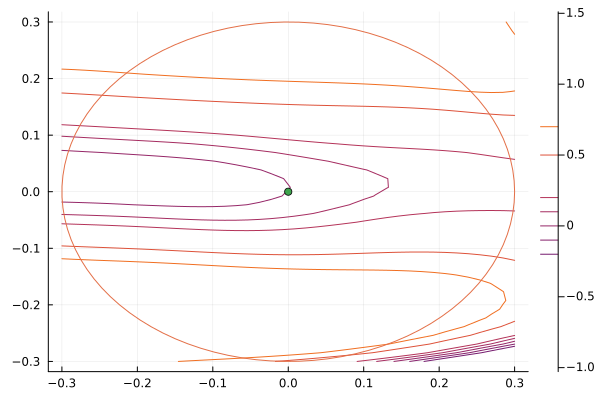

In [5]:
λ = E.values[end]
w = E.vectors[:, end]

using SumOfSquares
r = 0.3
X = @set x[1]^2 + x[2]^2 ≤ r^2

import CSDP
model = SOSModel(CSDP.Optimizer)
@variable(model, γ)
@objective(model, Min, γ)
@variable(model, ϕN, Poly(monomials(x, 2:10)))
ϕ = w ⋅ x + ϕN
∇ϕ = differentiate(ϕ, x)
@constraint(model, -γ ≤ F ⋅ ∇ϕ - λ * ϕ, domain = X)
@constraint(model, F ⋅ ∇ϕ - λ * ϕ ≤ γ, domain = X)
optimize!(model)
solution_summary(model)

ϕ_opt = value(ϕ)

using Plots
x1s = x2s = range(-0.3, stop = 0.3, length = 40)
ϕs = ϕ_opt.(x1s', x2s)
contour(x1s, x2s, ϕs, levels=[-0.2, -0.1, 0, 0.1, 0.2, 0.5, 0.7])
θ = range(0, stop = 2π, length = 100)
plot!(r * cos.(θ), r * sin.(θ), label = "")
scatter!([0], [0], label = "")

We can compute the Laplace average as follows:

In [6]:
using DifferentialEquations
function S(t, x1, x2, solver = DifferentialEquations.Tsit5())
    tspan = (0.0, t)
    prob = DifferentialEquations.ODEProblem((v, p, t) -> [f(x => v) for f in F], [x1, x2], tspan)
    traj = DifferentialEquations.solve(prob, solver, reltol=1e-4, abstol=1e-4)
    return traj[end]
end

using QuadGK
function laplace_average(f, λ, x1, x2, T = 10, args...)
    v, _ = quadgk(0, T, rtol=1e-3) do t
        s = S(t, x1, x2, args...)
        return f(S(t, x1, x2, args...)) * exp(-λ * t)
    end
    return v / T
end

lap(x1, x2) = laplace_average(v -> ϕ_opt(x => v), λ, x1, x2, 10)
laplace = lap.(x1s', x2s)

40×40 Matrix{Float64}:
 0.617084  0.613209  0.608601  …  -14.2383    -18.8138     -24.0363
 0.86143   0.856278  0.850627      -3.49322    -5.19986     -7.61694
 0.994453  0.988451  0.982044      -0.581209   -1.03529     -1.72087
 1.06688   1.06031   1.05338        0.124015   -0.0129393   -0.208898
 1.09543   1.08847   1.08122        0.329183    0.266501     0.188519
 1.08961   1.08241   1.07494   …    0.40636     0.363716     0.316463
 1.05676   1.04943   1.04187        0.435844    0.401089     0.36446
 1.00307   0.995724  0.988169       0.438324    0.408528     0.377636
 0.933822  0.926565  0.919108       0.421966    0.396239     0.369738
 0.853505  0.846416  0.839146       0.392001    0.369926     0.347244
 ⋮                             ⋱                           
 0.22719   0.230438  0.233771       0.436073    0.446151     0.456567
 0.296731  0.300181  0.303719       0.514295    0.524531     0.535057
 0.371222  0.374829  0.378527       0.59556     0.605841     0.616355
 0.449861  0

The error is given by:

In [7]:
norm(laplace - ϕs)

37.43987249730339

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*